In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
from pathlib import Path
from tqdm import tqdm
from numpy import array
import sys
sys.path.append("..")
from core.utils import *
import atlas_mpl_style as ampl
#ampl.use_atlas_style(usetex=False)
import random
import mplhep as hep
hep.style.use("ATLAS")

In [2]:
#nominal_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/uncertainty/SFs_pkls'
#nominal_path = Path(nominal_path)

reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT"
}
Map_gen={
"nominal": "PYTHIA",
"hadronization/sherpa": "SHERPA (Cluster Had.)",
"hadronization/sherpalund": "SHERPA (String Had.)",
"matrix_element/powhegpythia":"POWHEG + PYTHIA",
"parton_shower/herwigangle":"HERWIG (Angular Shower)",
"parton_shower/herwigdipole":"HERWIG (Dipole Shower)",
}

In [3]:
pkl_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots_new'
#pkl_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'

def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio

In [4]:
def Plot_WP(WP, var, output_path, period, reweighting_var,
            quark_effs, gluon_rejs, quark_effs_data, gluon_rejs_data,
            syst,if_save=True):
    
    SF_quark = safe_array_divide_unumpy(quark_effs_data, quark_effs)
    SF_gluon = safe_array_divide_unumpy(gluon_rejs_data, gluon_rejs)
    #print("SF: ",SF_gluon)

    if if_save:
        bin_edges = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
        bin_centers = 1/2 * (bin_edges[:-1] + bin_edges[1:])

        plt.rcParams["figure.figsize"] = (8,6)

        fig, ax0 = plt.subplots()
        #ax2=ax0.twinx()
        #if syst == 'nominal':

            #for ii, l_pt in enumerate(label_ptrange[:-1]):
                #plt.scatter(unumpy.nominal_values(quark_effs[ii]),unumpy.nominal_values(gluon_rejs[ii]),label=f'Quark jets {l_pt}',marker='^',color = "blue")
        #hep.histplot(unumpy.nominal_values(quark_effs),bins=label_ptrange,label='Quark Efficiency, Pythia',ax=ax2,histtype='errorbar',yerr = unumpy.std_devs(quark_effs),xerr=True,marker='o',mfc = 'none',color = "blue",markersize=9)
        #hep.histplot(unumpy.nominal_values(quark_effs),bins=label_ptrange,label=f'Quark Efficiency,{Map_gen[syst]}',ax=ax2,histtype='errorbar',yerr = unumpy.std_devs(quark_effs),xerr=True,marker='o',mfc = 'none',color = "blue",markersize=9)
        #hep.histplot(unumpy.nominal_values(quark_effs_data),bins=label_ptrange,label='Quark Efficiency, Data',ax=ax2,histtype='errorbar',yerr = unumpy.std_devs(quark_effs_data),xerr=True,marker='o',color = "blue",markersize=9)

        #hep.histplot(unumpy.nominal_values(gluon_rejs),bins=label_ptrange,label='Gluon Rejection, Pythia',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs),xerr=True,marker='v',mfc = 'none',color = "red",markersize=9)
        hep.histplot(unumpy.nominal_values(gluon_rejs),bins=label_ptrange,label=f'Gluon Rejection,{Map_gen[syst]}',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs),xerr=True,marker='v',mfc = 'none',color = "red",markersize=9)
        hep.histplot(unumpy.nominal_values(gluon_rejs_data),bins=label_ptrange,label='Gluon Rejection, Data',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs_data),xerr=True,marker='v',color = "red",markersize=9)

        # else:
        #     hep.histplot(unumpy.nominal_values(quark_effs),bins=label_ptrange,label=f'Quark Efficiency,{Map_gen[syst]}',ax=ax2,histtype='errorbar',yerr = unumpy.std_devs(quark_effs),xerr=True,marker='^',markersize=5)
        #     hep.histplot(unumpy.nominal_values(gluon_rejs),bins=label_ptrange,label=f'Gluon Rejection,{Map_gen[syst]}',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs),xerr=True,marker='v',markersize=5)
        #lines, labels = ax2.get_legend_handles_labels()
        #lines2, labels2 = ax0.get_legend_handles_labels()
        #ax0.legend(lines + lines2, labels + labels2,loc='upper right')

        ax0.legend()
        #ax2.legend()
        WP1 =int(WP*100)

        if syst=='matrix_element/powhegpythia' and WP1==50:
            ax0.set_ylim(6, 32)
            ax0.text(label_ptrange[1],26,f'{WP1}% WP {Map_var_title[var]}')

        else:
            ax0.set_ylim(1, 22) #0.3，1.4
            ax0.text(label_ptrange[1],17,f'{WP1}% WP {Map_var_title[var]}')


        #ax2.set_ylim(0.38,1.1)
        #ax0.set_xlim(0.5, 0.6)
        #ax0.set_ylim(0.3, 1.4)
        ax0.set_xlim(label_ptrange[0], label_ptrange[-1])
        
        #ax2.set_ylabel("Quark Efficiency")
        ax0.set_ylabel('Gluon Rejection')
        #ax0.set_ylabel("a.u.")
        ax0.set_xlabel('$p_{\mathrm{T}}$ [GeV]')


        #ax0.grid()
#        ax0.set_title(f"{var} for extracted q/g at {WP} WP")
        hep.atlas.label(data=True,ax=ax0,lumi=140)

        # ax1.errorbar(x = bin_centers, y = unumpy.nominal_values(SF_quark), yerr = unumpy.std_devs(SF_quark), linestyle='none', label = "quark SF", marker='.')
        # ax1.errorbar(x = bin_centers, y = unumpy.nominal_values(SF_gluon), yerr = unumpy.std_devs(SF_gluon), linestyle='none', label = "gluon SF", marker='.')
        # ax1.legend(fontsize = 'x-small')
        # ax1.set_ylim(0.7, 1.3)
        # ax1.set_xlim(bin_edges[0], bin_edges[-1])
        # #ampl.plot.set_xlabel(f"{Map_var_title[var]}")
        # #ax1.set_xticks(bin_edges)
        # ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'gray', linestyle = '--')
        # ax1.set_ylabel("SFs")
        output_path=Path(output_path)
        output_path_new = output_path / period / "WPs" / reweighting_var / var
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True)

        plt.show()
        #fig.savefig( output_path_new/ f"{reweighting_var}_WP_{WP}.pdf",dpi=fig.dpi, bbox_inches='tight')
        #plt.close()

    return SF_quark, SF_gluon

mc:  [11.263004231192335+/-0.04210268362603583] data:  [11.13664601714104+/-0.06836330380126147]
mc:  [11.263004231192335+/-0.04210268362603583, 10.715885647408694+/-0.03497161296363556] data:  [11.13664601714104+/-0.06836330380126147, 9.984440958972998+/-0.07022732070218568]
mc:  [11.263004231192335+/-0.04210268362603583, 10.715885647408694+/-0.03497161296363556, 10.798014940287034+/-0.05114842601361462] data:  [11.13664601714104+/-0.06836330380126147, 9.984440958972998+/-0.07022732070218568, 9.337360352854624+/-0.16471964312018156]
mc:  [11.263004231192335+/-0.04210268362603583, 10.715885647408694+/-0.03497161296363556, 10.798014940287034+/-0.05114842601361462, 10.32568887063383+/-0.08115621485416322] data:  [11.13664601714104+/-0.06836330380126147, 9.984440958972998+/-0.07022732070218568, 9.337360352854624+/-0.16471964312018156, 7.996227037502385+/-0.3144556187605237]
mc:  [11.263004231192335+/-0.04210268362603583, 10.715885647408694+/-0.03497161296363556, 10.798014940287034+/-0.051

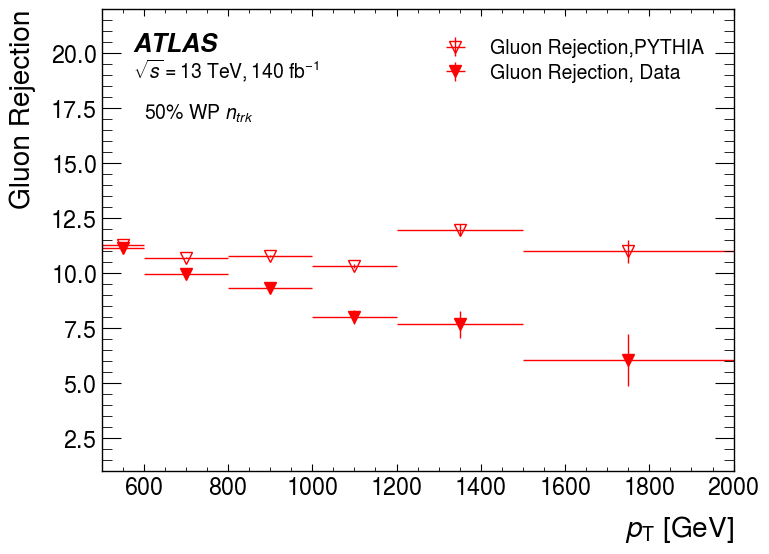

mc:  [6.272489207787589+/-0.015100659006419995] data:  [6.1692456897742005+/-0.02433771438148962]
mc:  [6.272489207787589+/-0.015100659006419995, 6.228129166809231+/-0.013397975788083473] data:  [6.1692456897742005+/-0.02433771438148962, 5.876252130446204+/-0.027635780156310918]
mc:  [6.272489207787589+/-0.015100659006419995, 6.228129166809231+/-0.013397975788083473, 6.513373824990033+/-0.020753981969478138] data:  [6.1692456897742005+/-0.02433771438148962, 5.876252130446204+/-0.027635780156310918, 5.8267531911202095+/-0.07168790979659653]
mc:  [6.272489207787589+/-0.015100659006419995, 6.228129166809231+/-0.013397975788083473, 6.513373824990033+/-0.020753981969478138, 6.4608352512939895+/-0.03468121512620684] data:  [6.1692456897742005+/-0.02433771438148962, 5.876252130446204+/-0.027635780156310918, 5.8267531911202095+/-0.07168790979659653, 5.338586753401443+/-0.15441713422323966]
mc:  [6.272489207787589+/-0.015100659006419995, 6.228129166809231+/-0.013397975788083473, 6.5133738249900

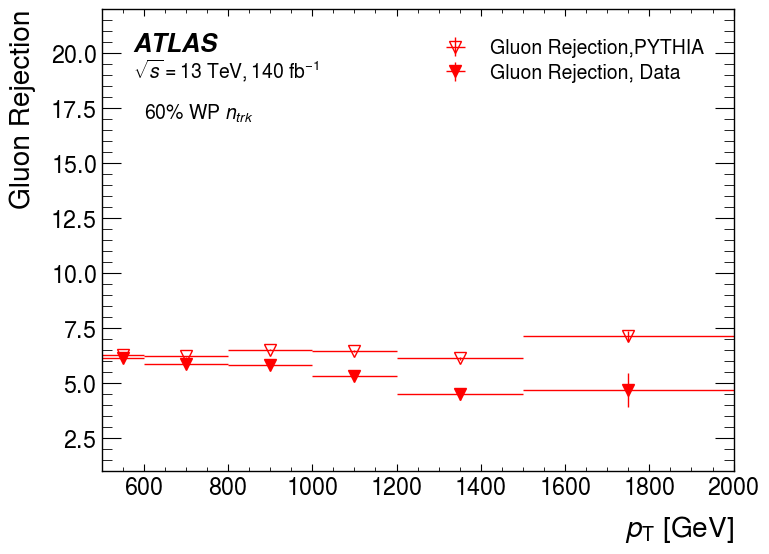

mc:  [3.9767914909201716+/-0.006820338497970031] data:  [3.9338036127402214+/-0.011125024399154923]
mc:  [3.9767914909201716+/-0.006820338497970031, 4.067856618123479+/-0.006324198888747965] data:  [3.9338036127402214+/-0.011125024399154923, 3.880914765589834+/-0.013332029057513245]
mc:  [3.9767914909201716+/-0.006820338497970031, 4.067856618123479+/-0.006324198888747965, 4.367049171615341+/-0.01019085729872705] data:  [3.9338036127402214+/-0.011125024399154923, 3.880914765589834+/-0.013332029057513245, 3.990116939209074+/-0.03671469119116642]
mc:  [3.9767914909201716+/-0.006820338497970031, 4.067856618123479+/-0.006324198888747965, 4.367049171615341+/-0.01019085729872705, 4.450377203799791+/-0.0176894931314507] data:  [3.9338036127402214+/-0.011125024399154923, 3.880914765589834+/-0.013332029057513245, 3.990116939209074+/-0.03671469119116642, 3.873890601003306+/-0.08786231370439748]
mc:  [3.9767914909201716+/-0.006820338497970031, 4.067856618123479+/-0.006324198888747965, 4.3670491716

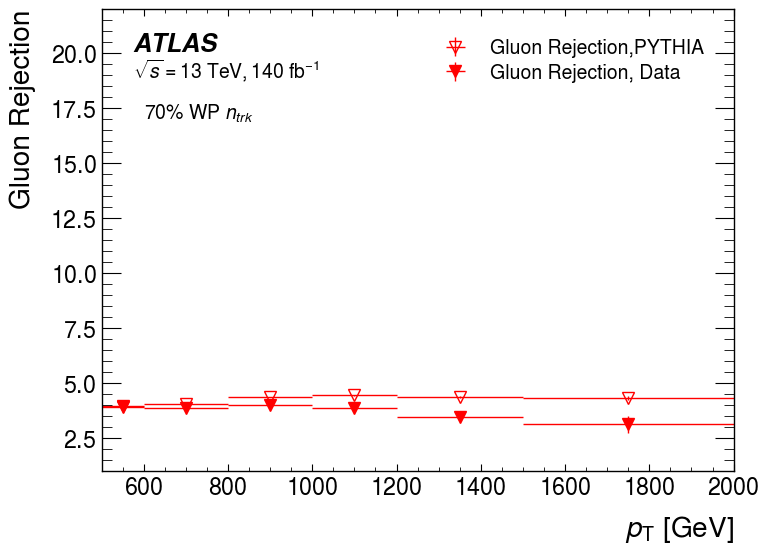

mc:  [2.8072476644558635+/-0.0037340071371325524] data:  [2.780015556140448+/-0.006099254127474044]
mc:  [2.8072476644558635+/-0.0037340071371325524, 2.5487921417233603+/-0.00279223056165107] data:  [2.780015556140448+/-0.006099254127474044, 2.4581398387794104+/-0.005999436241246311]
mc:  [2.8072476644558635+/-0.0037340071371325524, 2.5487921417233603+/-0.00279223056165107, 2.790064294944817+/-0.004612272273068666] data:  [2.780015556140448+/-0.006099254127474044, 2.4581398387794104+/-0.005999436241246311, 2.6169710045128105+/-0.017471200476651072]
mc:  [2.8072476644558635+/-0.0037340071371325524, 2.5487921417233603+/-0.00279223056165107, 2.790064294944817+/-0.004612272273068666, 2.5972023513268967+/-0.006727383556519714] data:  [2.780015556140448+/-0.006099254127474044, 2.4581398387794104+/-0.005999436241246311, 2.6169710045128105+/-0.017471200476651072, 2.37575827490657+/-0.03700104357722294]
mc:  [2.8072476644558635+/-0.0037340071371325524, 2.5487921417233603+/-0.00279223056165107, 

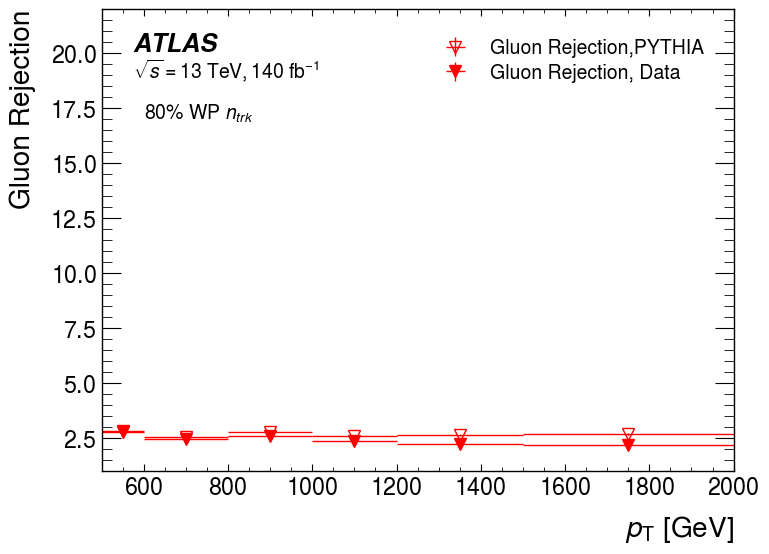

mc:  [14.619903826349963+/-0.06844342604126553] data:  [14.078346889397793+/-0.10550775285230578]
mc:  [14.619903826349963+/-0.06844342604126553, 15.035416073398922+/-0.0637143084647633] data:  [14.078346889397793+/-0.10550775285230578, 13.22259849125241+/-0.11470692430100957]
mc:  [14.619903826349963+/-0.06844342604126553, 15.035416073398922+/-0.0637143084647633, 15.13366403341195+/-0.09242337894653313] data:  [14.078346889397793+/-0.10550775285230578, 13.22259849125241+/-0.11470692430100957, 11.91919066566567+/-0.2472674255150954]
mc:  [14.619903826349963+/-0.06844342604126553, 15.035416073398922+/-0.0637143084647633, 15.13366403341195+/-0.09242337894653313, 15.414735545923206+/-0.16324863055578093] data:  [14.078346889397793+/-0.10550775285230578, 13.22259849125241+/-0.11470692430100957, 11.91919066566567+/-0.2472674255150954, 10.261805999906452+/-0.4665270923353264]
mc:  [14.619903826349963+/-0.06844342604126553, 15.035416073398922+/-0.0637143084647633, 15.13366403341195+/-0.092423

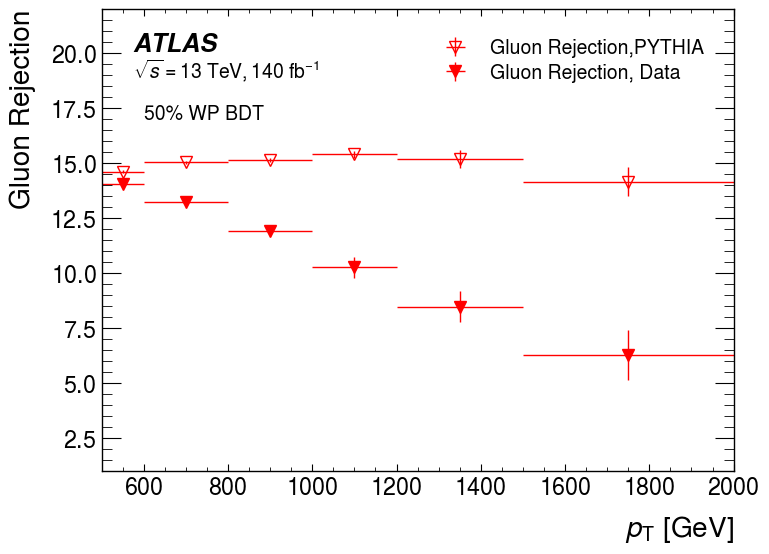

mc:  [8.820009431407092+/-0.028009919933947802] data:  [8.281692450956763+/-0.041429302348905746]
mc:  [8.820009431407092+/-0.028009919933947802, 9.039713135123792+/-0.025732744229804882] data:  [8.281692450956763+/-0.041429302348905746, 7.946497353737989+/-0.04661680075695995]
mc:  [8.820009431407092+/-0.028009919933947802, 9.039713135123792+/-0.025732744229804882, 8.982796757102985+/-0.03618019404064973] data:  [8.281692450956763+/-0.041429302348905746, 7.946497353737989+/-0.04661680075695995, 7.298813155789267+/-0.10398153433561018]
mc:  [8.820009431407092+/-0.028009919933947802, 9.039713135123792+/-0.025732744229804882, 8.982796757102985+/-0.03618019404064973, 9.150978866995796+/-0.06315315536074069] data:  [8.281692450956763+/-0.041429302348905746, 7.946497353737989+/-0.04661680075695995, 7.298813155789267+/-0.10398153433561018, 6.646512993005031+/-0.21831742723618114]
mc:  [8.820009431407092+/-0.028009919933947802, 9.039713135123792+/-0.025732744229804882, 8.982796757102985+/-0.0

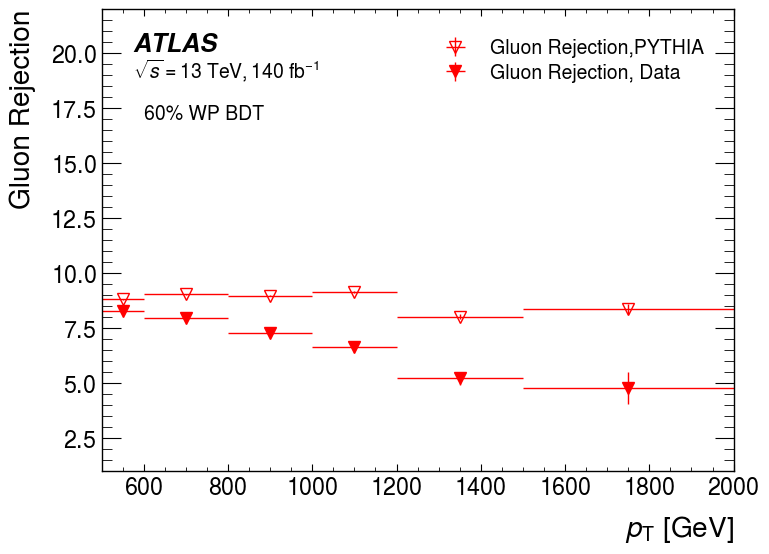

mc:  [5.338802205349208+/-0.011588197824748566] data:  [4.894134748631426+/-0.016461144973971026]
mc:  [5.338802205349208+/-0.011588197824748566, 5.489899173460075+/-0.010634392174148997] data:  [4.894134748631426+/-0.016461144973971026, 4.7910121201382605+/-0.019096154868997503]
mc:  [5.338802205349208+/-0.011588197824748566, 5.489899173460075+/-0.010634392174148997, 5.458415522087744+/-0.01487598292150983] data:  [4.894134748631426+/-0.016461144973971026, 4.7910121201382605+/-0.019096154868997503, 4.498400117972759+/-0.04422044984170575]
mc:  [5.338802205349208+/-0.011588197824748566, 5.489899173460075+/-0.010634392174148997, 5.458415522087744+/-0.01487598292150983, 5.602626041880517+/-0.025975976268045296] data:  [4.894134748631426+/-0.016461144973971026, 4.7910121201382605+/-0.019096154868997503, 4.498400117972759+/-0.04422044984170575, 4.3111013232893+/-0.10196592441190182]
mc:  [5.338802205349208+/-0.011588197824748566, 5.489899173460075+/-0.010634392174148997, 5.458415522087744+

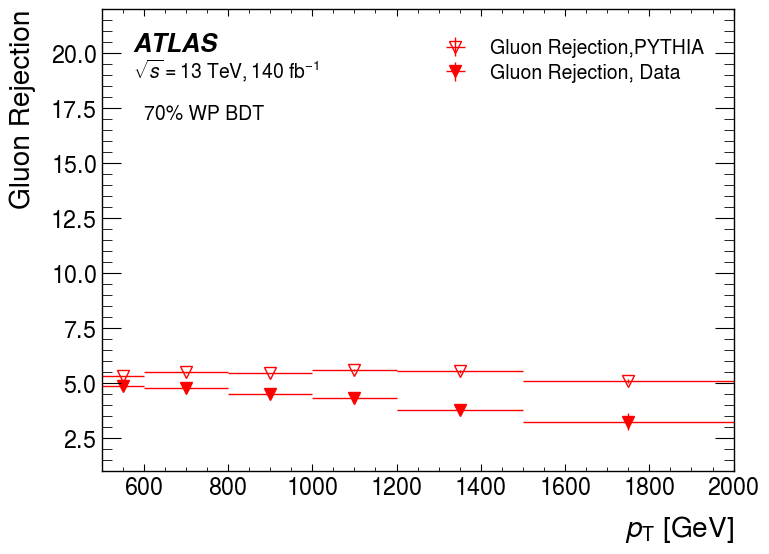

mc:  [3.512327840110338+/-0.005577848418854626] data:  [3.1897735785366343+/-0.007795680711864474]
mc:  [3.512327840110338+/-0.005577848418854626, 3.610075821077531+/-0.005079922767312002] data:  [3.1897735785366343+/-0.007795680711864474, 3.1656479843794125+/-0.009216329870887672]
mc:  [3.512327840110338+/-0.005577848418854626, 3.610075821077531+/-0.005079922767312002, 3.6057099884262493+/-0.007108985036236446] data:  [3.1897735785366343+/-0.007795680711864474, 3.1656479843794125+/-0.009216329870887672, 3.037460505625705+/-0.022102731325392182]
mc:  [3.512327840110338+/-0.005577848418854626, 3.610075821077531+/-0.005079922767312002, 3.6057099884262493+/-0.007108985036236446, 3.3387578152785085+/-0.010213838400361469] data:  [3.1897735785366343+/-0.007795680711864474, 3.1656479843794125+/-0.009216329870887672, 3.037460505625705+/-0.022102731325392182, 2.701586891532011+/-0.04461221034149315]
mc:  [3.512327840110338+/-0.005577848418854626, 3.610075821077531+/-0.005079922767312002, 3.605

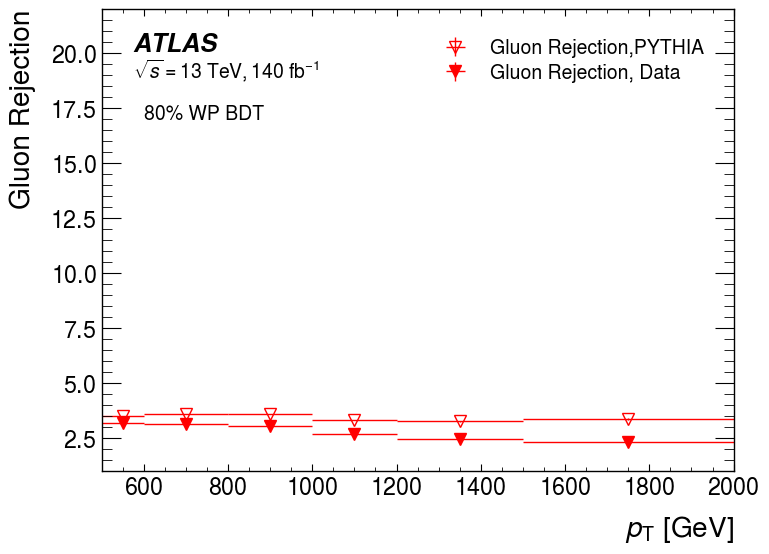

In [5]:
SFs = {}
Eff={}
Extraction_Results={}
syst_list=['nominal']#,'matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole','hadronization/sherpa','hadronization/sherpalund']
#WP_cut_path = pkl_path/'nominal'/'plots'/'ADE'/'WP_cuts_pkls'/nominal_keys/'WP_cuts.pkl'
#WP_cut = joblib.load(WP_cut_path)
#WP_cut = dict.fromkeys(SF_label_vars)
for var in reweighting_vars:
    SFs[var] = {}
    Eff[var]={}
    WP_cut_path = pkl_path/'nominal'/'plots'/'ADE'/'WP_cuts_pkls'/ f'{var}_quark_reweighting_weights'/'WP_cuts.pkl'
    #WP_cut_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new_hrzhao/nominal/plots/ADE/WP_cuts_pkls/jet_nTracks_quark_reweighting_weights/WP_cuts.pkl'
    WP_cut = joblib.load(WP_cut_path)
    #WP_cut = dict.fromkeys(var)
    #WP_cut[var] = dict.fromkeys(WPs)
    for syst in syst_list:
        SFs[var][syst]={}
        Eff[var][syst]={} 
        syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'

        Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
        output_path = f'../eff_gen/{syst}'

        for l_pt in label_ptrange[:-1]:
            Extraction_var_pt =  Extraction_Results[syst][var][l_pt]


        for WP in WPs:
            #WP_cut[var][WP] = dict.fromkeys(label_ptrange[:-1])
            SFs[var][syst][WP] = {}
            Eff[var][syst][WP] = {}

            quark_effs_at_pt = []
            gluon_rejs_at_pt = []
            quark_effs_data_at_pt = []
            gluon_rejs_data_at_pt = []
            for ii, l_pt in enumerate(label_ptrange[:-1]):
                extract_p_Quark_MC =  Extraction_Results[syst][var][l_pt]['extract_p_Quark_MC']
                extract_p_Gluon_MC =  Extraction_Results[syst][var][l_pt]['extract_p_Gluon_MC']
                extract_p_Quark_Data =  Extraction_Results[syst][var][l_pt]['extract_p_Quark_Data']
                extract_p_Gluon_Data =  Extraction_Results[syst][var][l_pt]['extract_p_Gluon_Data']

                extract_p_Quark_cum_sum = np.cumsum(unumpy.nominal_values(extract_p_Quark_MC))
                cut = np.where(extract_p_Quark_cum_sum >= WP)[0][0]+1
                #cut = WP_cut[var][WP][l_pt]['idx']
                

                quark_effs_at_pt.append(np.sum(extract_p_Quark_MC[:cut])) 
                #gluon_rejs_at_pt.append(1.0/np.sum(extract_p_Gluon_MC[cut:]))
                gluon_rejs_at_pt.append(1.0/np.sum(extract_p_Gluon_MC[:cut]))

                #quark_effs_at_pt.append(1.0/ np.sum(extract_p_Quark_MC[:cut])) ##g tagging eff
                #gluon_rejs_at_pt.append(np.sum(extract_p_Gluon_MC[cut:])) ##g tagging eff

                quark_effs_data_at_pt.append(np.sum(extract_p_Quark_Data[:cut]))
                #gluon_rejs_data_at_pt.append(1.0/np.sum(extract_p_Gluon_Data[cut:]))
                gluon_rejs_data_at_pt.append(1.0/np.sum(extract_p_Gluon_Data[:cut]))
                #gluon_rejs_data_at_pt.append(np.sum(extract_p_Gluon_Data[cut:]))
                print('mc: ',gluon_rejs_at_pt,'data: ',gluon_rejs_data_at_pt)


            SF_quark, SF_gluon = Plot_WP(WP = WP, var= var, output_path= output_path, 
                    period= 'ADE', reweighting_var = var,
                    quark_effs= quark_effs_at_pt, gluon_rejs = gluon_rejs_at_pt,
                    quark_effs_data=quark_effs_data_at_pt, gluon_rejs_data = gluon_rejs_data_at_pt,syst=syst)
            
            SFs[var][syst][WP]["Quark"] = SF_quark
            SFs[var][syst][WP]["Gluon"] = SF_gluon
            Eff[var][syst][WP]["Quark"] = quark_effs_at_pt
            Eff[var][syst][WP]["Gluon"] = gluon_rejs_at_pt 
            Eff[var][syst][WP]["Quark_data"] = quark_effs_data_at_pt 
            Eff[var][syst][WP]["Gluon_data"] = gluon_rejs_data_at_pt 


In [6]:
Eff['jet_nTracks']['nominal'][0.5].keys()

dict_keys(['Quark', 'Gluon', 'Quark_data', 'Gluon_data'])

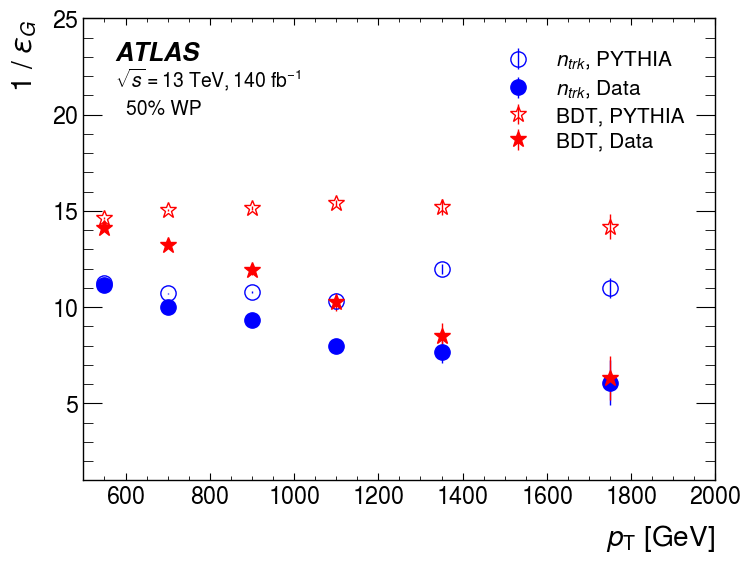

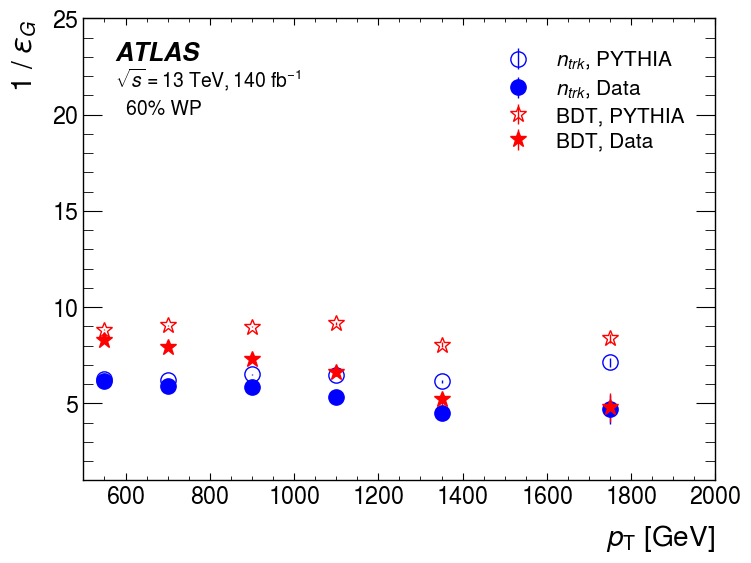

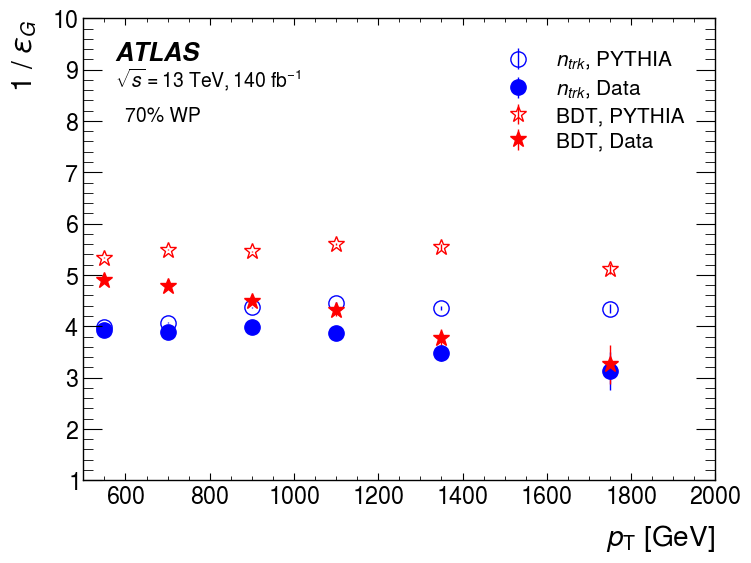

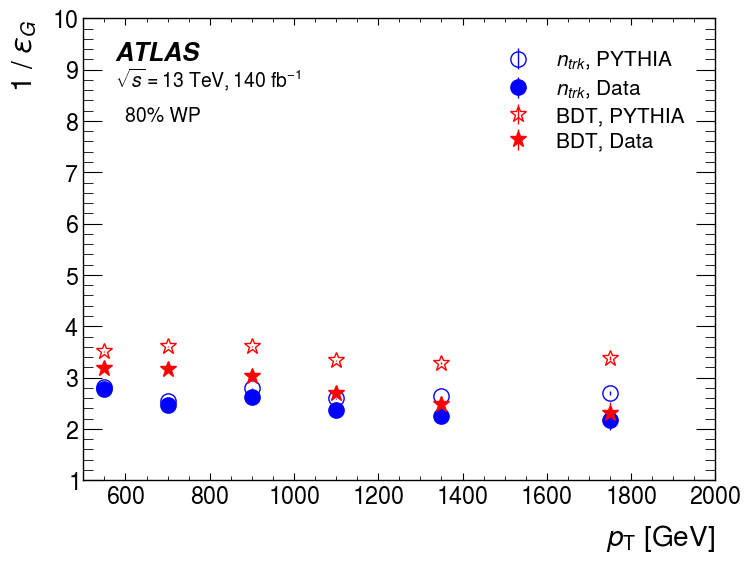

In [6]:
for WP in WPs:
    WP1=int(WP*100)
    fig, ax = plt.subplots()
    quark_nominal_values= unumpy.nominal_values(Eff['jet_nTracks']['nominal'][WP]['Gluon'])
    q_dev=unumpy.std_devs(Eff['jet_nTracks']['nominal'][WP]['Gluon'])       
    quark_nominal_values_d= unumpy.nominal_values(Eff['jet_nTracks']['nominal'][WP]['Gluon_data'])
    q_dev_d=unumpy.std_devs(Eff['jet_nTracks']['nominal'][WP]['Gluon_data'])       

    quark_nominal_values_bdt= unumpy.nominal_values(Eff['GBDT_newScore']['nominal'][WP]['Gluon'])
    q_dev_bdt=unumpy.std_devs(Eff['GBDT_newScore']['nominal'][WP]['Gluon'])       
    quark_nominal_values_d_bdt= unumpy.nominal_values(Eff['GBDT_newScore']['nominal'][WP]['Gluon_data'])
    q_dev_d_bdt=unumpy.std_devs(Eff['GBDT_newScore']['nominal'][WP]['Gluon_data'])     

    hep.histplot(quark_nominal_values,bins=label_ptrange,label=r'$n_{trk}$, PYTHIA',ax=ax,histtype='errorbar',yerr = q_dev,marker='o',mfc = 'none',color = "blue",markersize=11)
    hep.histplot(quark_nominal_values_d,bins=label_ptrange,label=r'$n_{trk}$, Data',ax=ax,histtype='errorbar',yerr = q_dev_d,marker='o',color = "blue",markersize=11)
    hep.histplot(quark_nominal_values_bdt,bins=label_ptrange,label='BDT, PYTHIA',ax=ax,histtype='errorbar',yerr = q_dev_bdt,marker='*',mfc = 'none',color = "red",markersize=12)
    hep.histplot(quark_nominal_values_d_bdt,bins=label_ptrange,label='BDT, Data',ax=ax,histtype='errorbar',yerr = q_dev_d_bdt,marker='*',color = "red",markersize=12)
    ax.set_xlim(label_ptrange[0], label_ptrange[-1])

    ax.set_xlabel('$p_{\mathrm{T}}$ [GeV]')
    ax.set_ylabel(r'1 / $\epsilon_G$')        
    ax.legend(fontsize=15,loc='upper right')

    # ax.set_ylim(1, 1.7)    
    # ax.text(label_ptrange[1],1.6,f'{WP1}% WP')
    if WP1>60:
        ax.set_ylim(1, 10)   #1,10
        ax.text(label_ptrange[1],8,f'{WP1}% WP')
    else:
        ax.set_ylim(1, 25)    #1,25
        ax.text(label_ptrange[1],20,f'{WP1}% WP')#20


    hep.atlas.label(ax=ax,lumi=140,data=True)

    fig.savefig(f"../eff_gen/WP{WP}.pdf")

In [7]:
import pandas as pd
jet_pt=['500-600', '600-800', '800-1000','1000-1200','1200-1500','1500-2000']


Eff_syst={}


for var in reweighting_vars:
    Eff_syst[var]={}
    for WP in WPs:
        Eff_syst[var][WP]={}
        for j in partons:
            Eff_syst[var][WP][j]={}
            for syst in Eff['jet_nTracks'].keys():
                Eff_syst[var][WP][j][f'{Map_gen[syst]}']= safe_array_divide_unumpy(Eff[var]['nominal'][WP][j], Eff[var][syst][WP][j])
                #Eff_syst[var][WP][j][f'{Map_gen[syst]}']= unumpy.nominal_values(safe_array_divide_unumpy(Eff[var]['nominal'][WP][j], Eff[var][syst][WP][j]))

            #df = pd.DataFrame.from_dict(Eff_syst[var][WP][j], orient="index",columns=jet_pt)
            #df[1:].to_latex(f'../tables/SF_MC_{var}_{WP}_{j}.tex',caption=f'Scale Factors of {j} for {var} at {WP} \% WP',label=f'tab:SF_MC_{var}_{WP}_{j}',float_format="%.2f",column_format='ccccccc')


In [16]:
Eff_syst['jet_nTracks'][0.5]['Gluon']['POWHEG + PYTHIA']

array([0.9316885722411914+/-0.0053349763019829655,
       0.6779787120264091+/-0.004055303701908373,
       0.6987250496841074+/-0.006765643581002075,
       0.733400973461083+/-0.010988836335504439,
       0.6955069805861995+/-0.034232233839354254,
       0.7309062650529902+/-0.04123428408977687], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

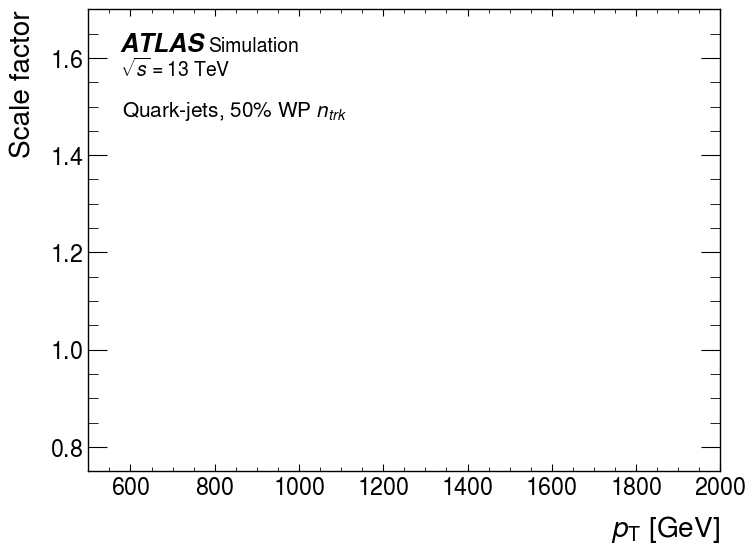

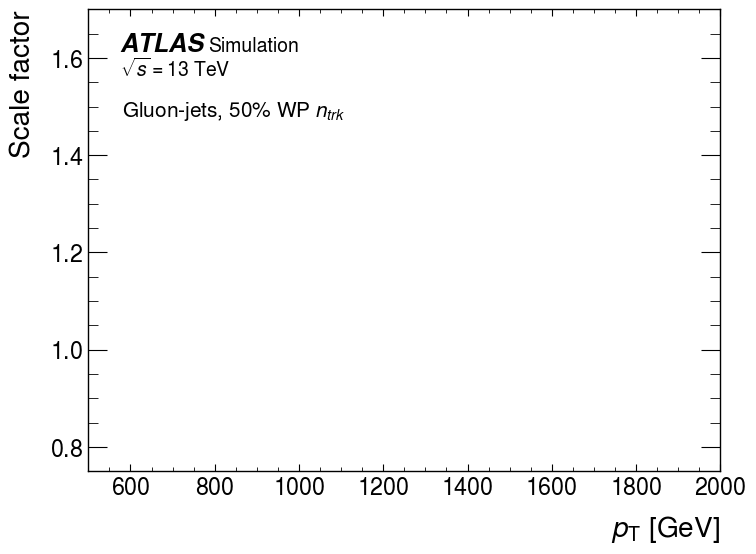

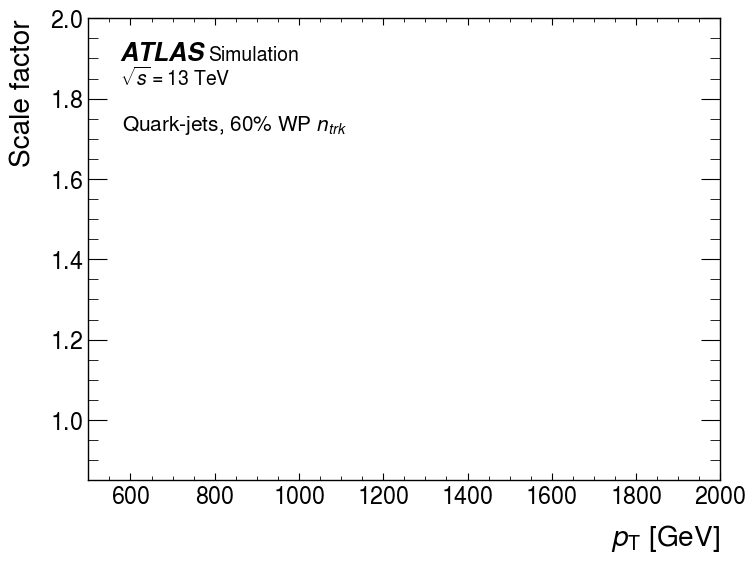

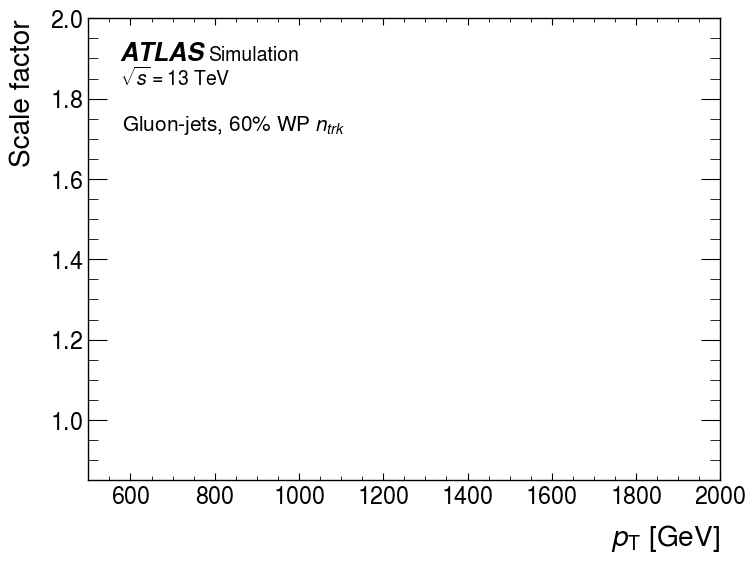

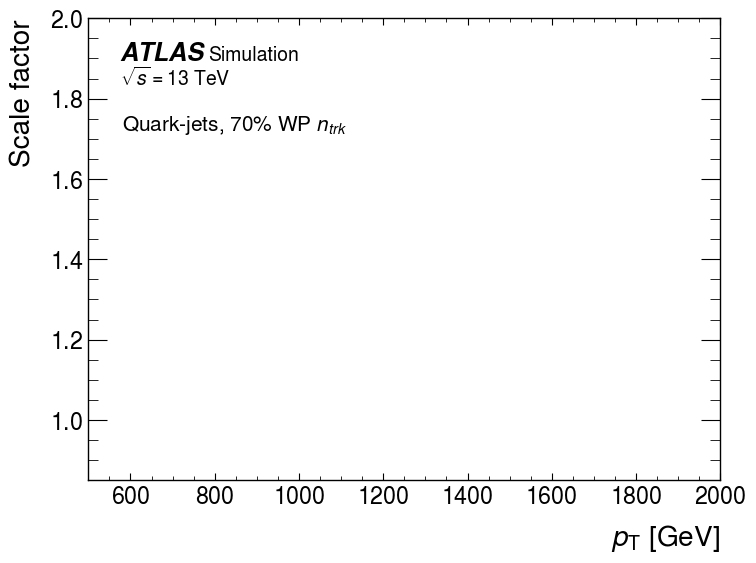

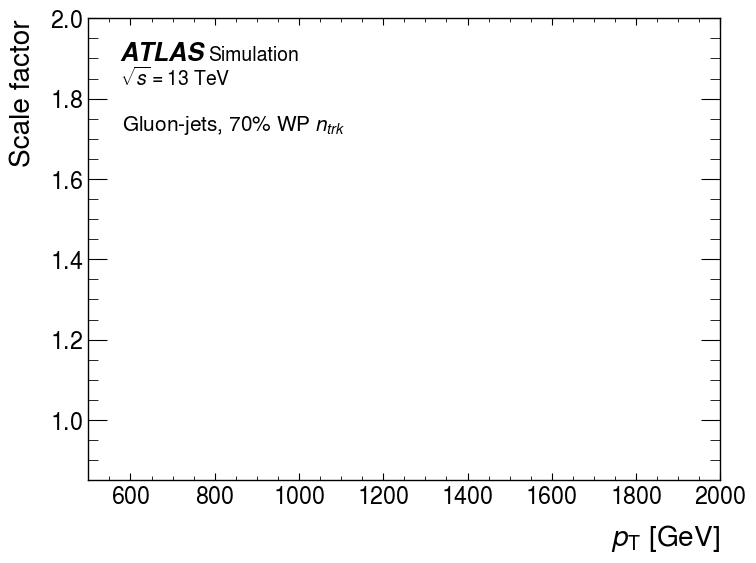

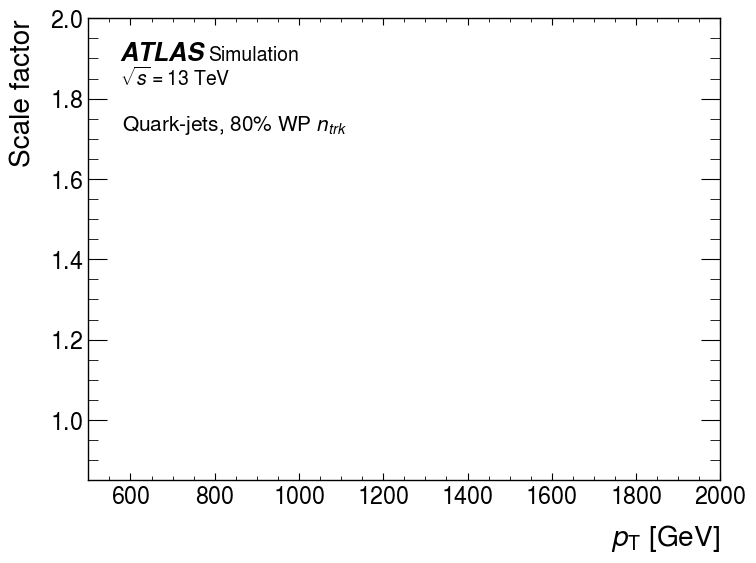

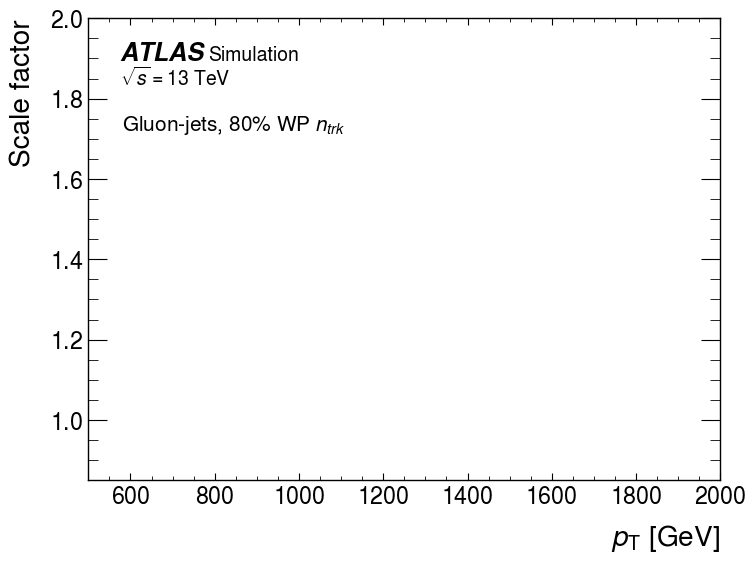

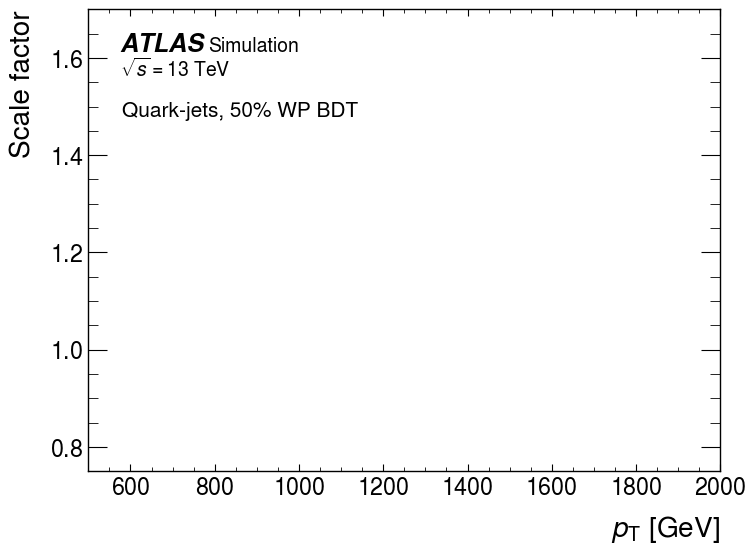

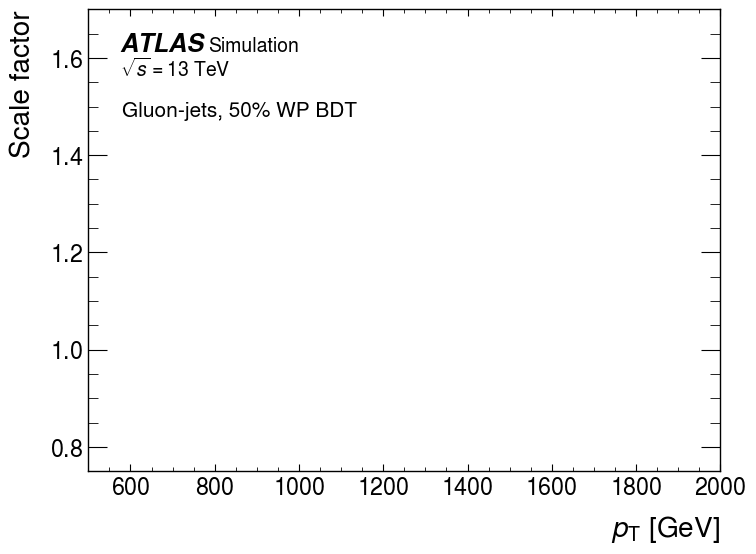

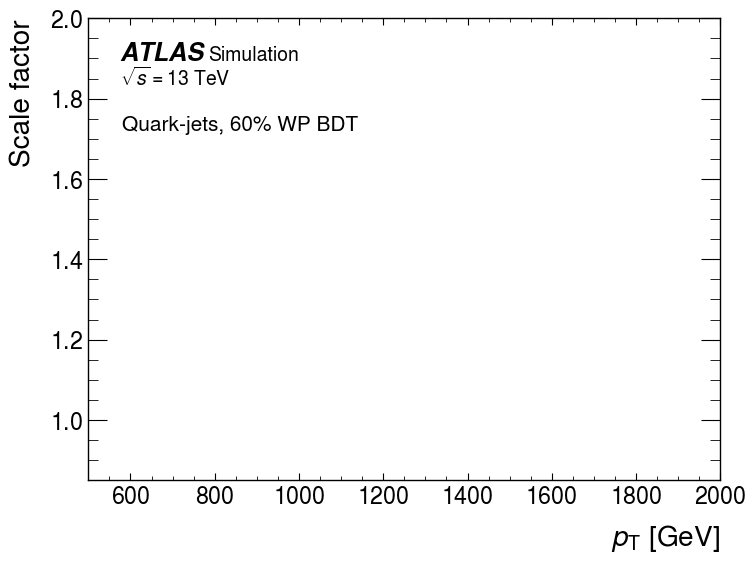

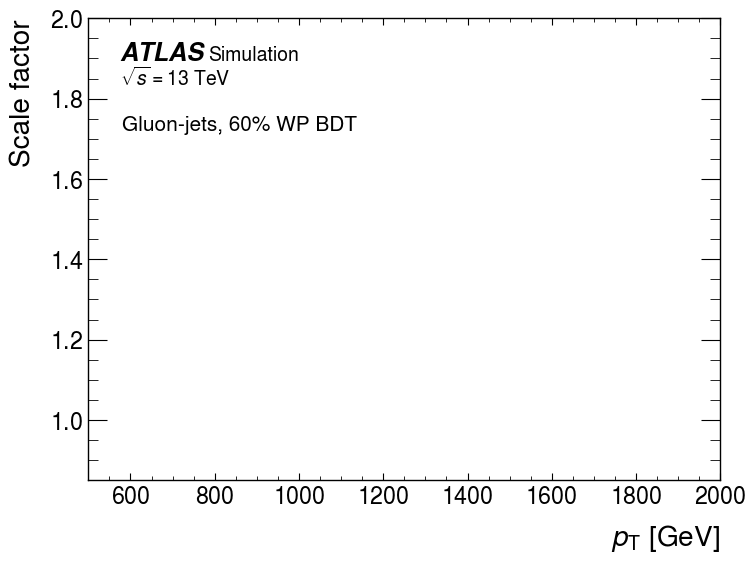

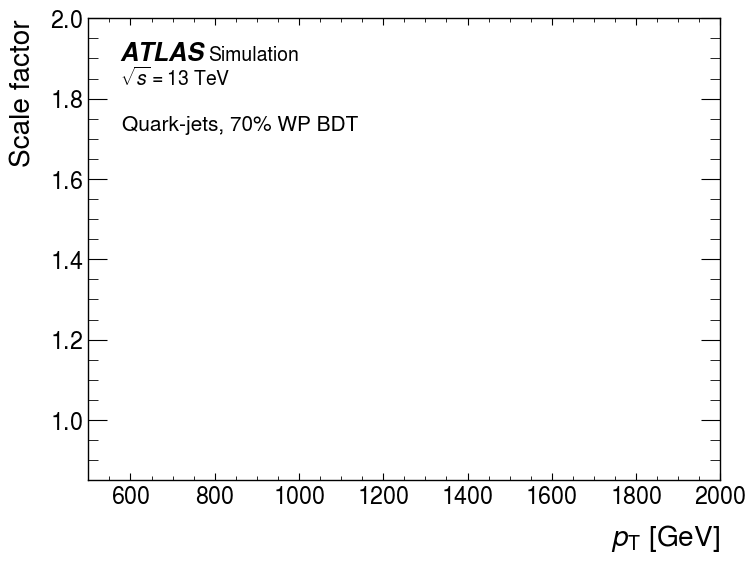

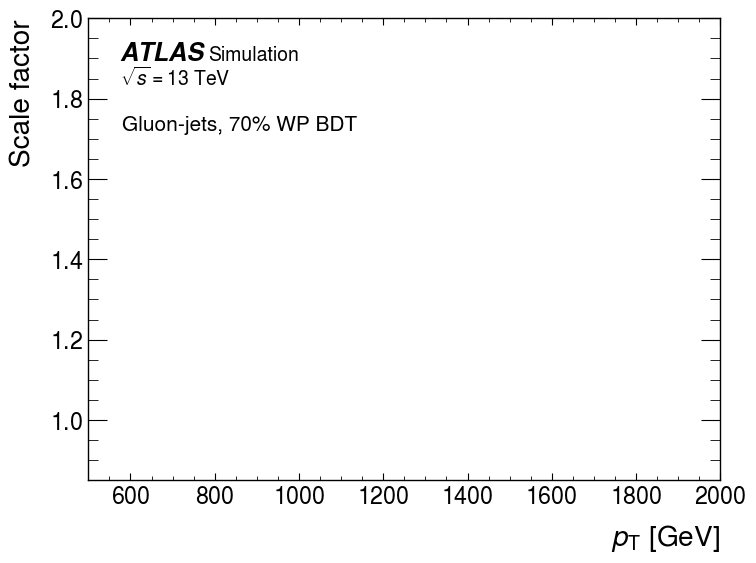

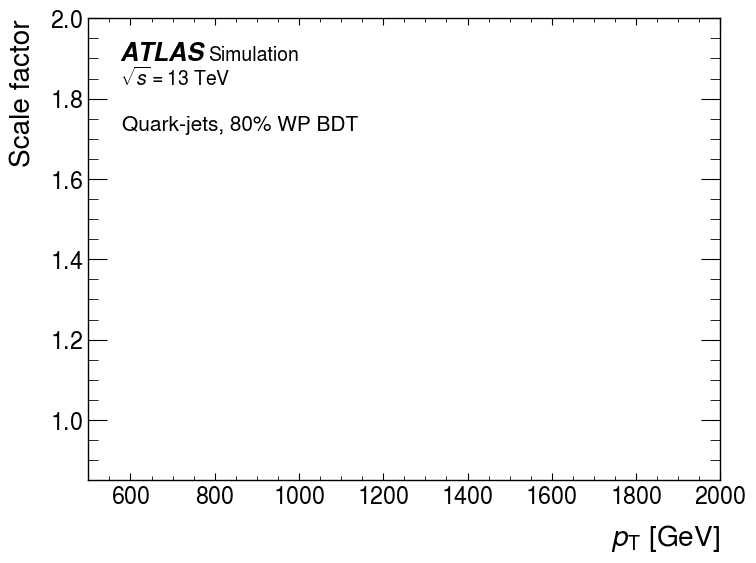

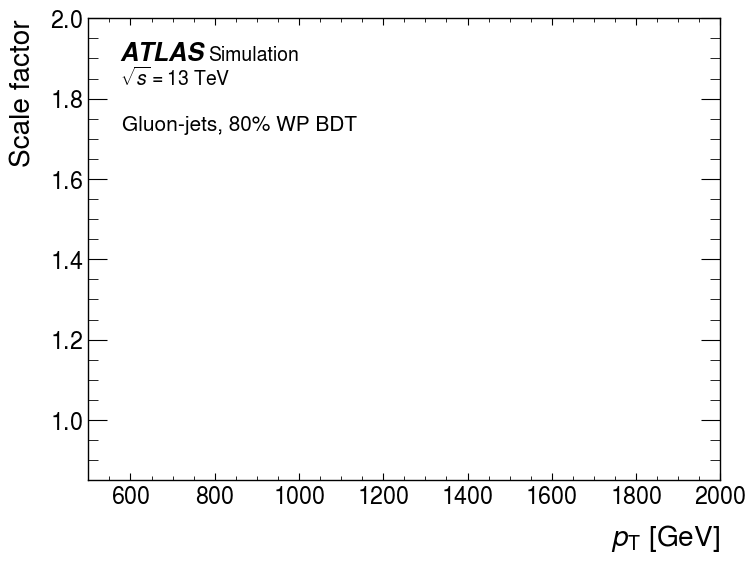

In [8]:
ind = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
ind_all = ind(15)
bin_centers1 = [500,700,900,1100,1350,2000]
#label_pt_bin = label_eta_bin
bin_centers = 0.5 * (np.array(label_pt_bin[:-1]) + np.array(label_pt_bin[1:]))

linestyle_list=['-',':',"-.","--"]
color_list=['firebrick','forestgreen','darkorange','orchid']
lines=['o','s','v','d','p','x','*','^']


for i_var, reweighting_var in enumerate(reweighting_vars):    
    for WP in WPs:
        WP1=int(WP*100)
        for parton in ['Quark','Gluon']:
            fig, ax = plt.subplots()
            ee=0
            for syst in Eff_syst[reweighting_var][WP][parton].keys():
                quark_nominal_values = unumpy.nominal_values(Eff_syst[reweighting_var][WP][parton][syst])
                q_dev=unumpy.std_devs(Eff_syst[reweighting_var][WP][parton][syst])           
                if syst != 'PYTHIA':
                    hep.histplot(quark_nominal_values,bins=label_ptrange,label=f'{syst}',ax=ax,histtype='errorbar',yerr=q_dev,mfc='none',marker=lines[ee],markersize=11)
                ee+=1

            ax.set_xlim(label_pt_bin[0], label_pt_bin[-1])
            if WP1>50:
                ax.set_ylim(0.85, 2)
                ax.text(580,1.72,f'{parton}-jets, {WP1}% WP {Map_var_title[reweighting_var]}',fontsize=15) #580  #0.1

            else:
                ax.set_ylim(0.75, 1.7)
                ax.text(580,1.48,f'{parton}-jets, {WP1}% WP {Map_var_title[reweighting_var]}',fontsize=15) #580  #0.1
            ax.set_xlabel('$p_{\mathrm{T}}$ [GeV]')

            ax.set_ylabel('Scale factor')
            ax.legend(fontsize=15,loc='upper right')
            hep.atlas.label(ax=ax)
            #hep.atlas.label(ax=ax,lumi=140,data=True)

            fig.savefig(f"../eff_gen/{reweighting_var}_WP{WP}_{parton}_gen.pdf")
            #fig.savefig(f"../syst_uncertainties_note_flate_eta/{reweighting_var}_WP{WP}_{parton}_comp.pdf")


In [28]:

df.head()

,500-600,600-800,800-1000,1000-1200,1200-1500,1500-2000
nominal,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hadronization/sherpa,0.934114,1.060333,1.049236,1.036101,0.950120,1.037539
hadronization/sherpalund,0.985758,1.003732,1.000756,1.088308,0.994862,1.000366
matrix_element/powhegpythia,0.962698,1.076796,1.056865,1.035018,1.023289,1.002227
parton_shower/herwigangle,1.002968,1.017459,1.020095,1.019295,1.011170,1.007737


/tmp/ipykernel_3284/3710522159.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(f'../tables/SF_MC.tex',caption=f'Scale Factors of \ntrk at 0.5 \% WP',label=f'tab:SF_MC',float_format="%.2f",column_format='ccccccc')
